# Training and evaluation of the comments model

This notebook contains the training of the model to classify a comment in the platform as positive or negative. It also contains a section where the model performance is evaluated.

- Created by: Juan Fernandez
- Created on: 2/Jan/2019
- Modified by: William Alexander
- Meidifed on: 16/March/2019

In [1]:
import requests

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [2]:
COMMENTS_URL = 'https://jsonplaceholder.typicode.com/comments'

### Data preprocessing

In [3]:
def get_comments(comments_url):
    comments = requests.get(comments_url).json()
    return pd.DataFrame(comments).drop(columns=['id'])

def get_labeled_comments(comments_url):
    comments = get_comments(comments_url)
    comments['sentiment'] = np.random.randint(0, 2, size=len(comments))
    return comments

def get_token_weigths(path):
    return pd.read_csv(path)

def _add_weight(x, tokens, weights):
    try:
        idx = tokens.index(x)
    except:
        return 1
    else:
        return weights[idx]

def create_dataset(comments, token_weights):
    comments['weights'] = comments['name'].apply(lambda x: _add_weight(x, token_weights['token'].tolist(), token_weights['weight'].tolist()))
    return comments

In [4]:
comments = get_labeled_comments(COMMENTS_URL)
comments.head()

,body,email,name,postId,sentiment
0,laudantium enim quasi est quidem magnam volupt...,Eliseo@gardner.biz,id labore ex et quam laborum,1,1
1,est natus enim nihil est dolore omnis voluptat...,Jayne_Kuhic@sydney.com,quo vero reiciendis velit similique earum,1,1
2,quia molestiae reprehenderit quasi aspernatur\...,Nikita@garfield.biz,odio adipisci rerum aut animi,1,0
3,non et atque\noccaecati deserunt quas accusant...,Lew@alysha.tv,alias odio sit,1,0
4,harum non quasi et ratione\ntempore iure ex vo...,Hayden@althea.biz,vero eaque aliquid doloribus et culpa,1,0


In [5]:
weights = get_token_weigths('token_weights.csv')
weights.head()

,token,weight
0,pa,0.388042
1,er,0.828243
2,x,0.476935
3,or,0.387840
4,a,0.485616


In [6]:
comments = create_dataset(comments, weights)
comments.head()

,body,email,name,postId,sentiment,weights
0,laudantium enim quasi est quidem magnam volupt...,Eliseo@gardner.biz,id labore ex et quam laborum,1,1,1
1,est natus enim nihil est dolore omnis voluptat...,Jayne_Kuhic@sydney.com,quo vero reiciendis velit similique earum,1,1,1
2,quia molestiae reprehenderit quasi aspernatur\...,Nikita@garfield.biz,odio adipisci rerum aut animi,1,0,1
3,non et atque\noccaecati deserunt quas accusant...,Lew@alysha.tv,alias odio sit,1,0,1
4,harum non quasi et ratione\ntempore iure ex vo...,Hayden@althea.biz,vero eaque aliquid doloribus et culpa,1,0,1


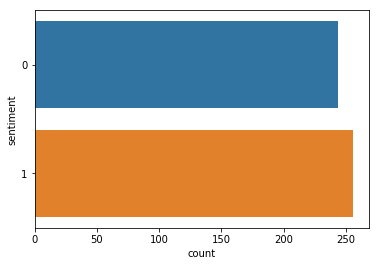

In [7]:
sns.countplot(y='sentiment', data=comments);

In [6]:
X_train, X_test, y_train, y_test = train_test_split(comments[['body', 'weights']], comments['sentiment'])
weights = X_train['weights']
X_train = X_train['body']
X_test = X_test['body']

### Feature engineering

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
print('Sparsity:', (np.prod(X.shape) - X.count_nonzero()) / np.prod(X.shape))

Sparsity: 0.879499079189687


### Training

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
forest = RandomForestClassifier()
forest = forest.fit(X, y_train, sample_weight=weights)

/home/rodrigo/anaconda3/envs/ds-flow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Evaluation

In [11]:
accuracy_score(y_test, forest.predict(vectorizer.transform(X_test)))

0.456